In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

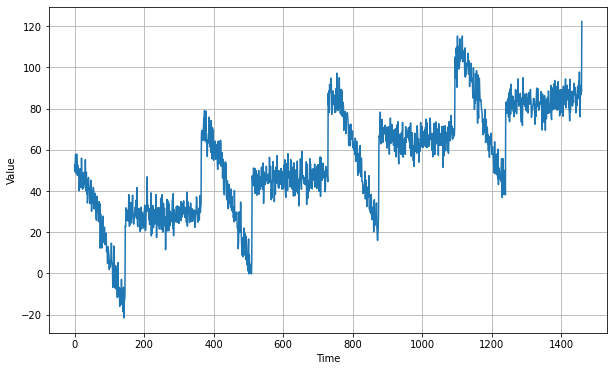

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def sequential_window_dataset(series, window_size):
  dataset = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[1: ]))
  return dataset.batch(1).prefetch(1)

In [6]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    # clear the hidden states in the network: to make consecutive model calls independent
    self.model.reset_states()

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True, 
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)           
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30)
)
reset_states = ResetStatesCallback()

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 8s 16ms/step - loss: 142.2544 - mae: 142.7542 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 134.9725 - mae: 135.4725 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 8ms/step - loss: 126.7331 - mae: 127.2325 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 8ms/step - loss: 117.9949 - mae: 118.4949 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 8ms/step - loss: 108.7230 - mae: 109.2228 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 8ms/step - loss: 98.8708 - mae: 99.3705 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 8ms/step - loss: 88.3919 - mae: 88.8916 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 8ms/step - loss: 77.2367 - mae: 77.7364 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 8ms/step - loss: 65.3472 - ma

(1e-08, 0.0001, 0.0, 30.0)

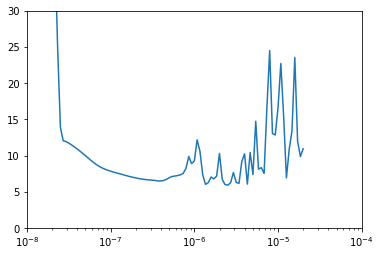

In [8]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)                             
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("lstm_rnn_checkpoint.h5", 
                                                      save_best_only=True)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=3e-7, momentum=0.9),
              metrics=["mae"])

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 4s 33ms/step - loss: 83.4523 - mae: 83.9515 - val_loss: 17.6852 - val_mae: 18.1825
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 22.8543 - mae: 23.3507 - val_loss: 24.3826 - val_mae: 24.8798
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 10.8293 - mae: 11.3186 - val_loss: 9.6446 - val_mae: 10.1381
Epoch 4/500
33/33 [==============================] - 0s 11ms/step - loss: 9.3555 - mae: 9.8448 - val_loss: 9.0912 - val_mae: 9.5796
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 7.8972 - mae: 8.3801 - val_loss: 9.1396 - val_mae: 9.6301
Epoch 6/500
33/33 [==============================] - 0s 11ms/step - loss: 7.4442 - mae: 7.9258 - val_loss: 8.0807 - val_mae: 8.5680
Epoch 7/500
33/33 [==============================] - 0s 11ms/step - loss: 7.1162 - mae: 7.5967 - val_loss: 7.6626 - val_mae: 8.1517
Epoch 8/500
33/33 [==============================] - 0s 11ms/step

In [10]:
model = tf.keras.models.load_model("lstm_rnn_checkpoint.h5")

In [11]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : , np.newaxis]) # batch, time stamps, dim
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[0, split_time - 1: -1, 0]

1/1 [==============================] - 1s 697ms/step
(1, 1461, 1)


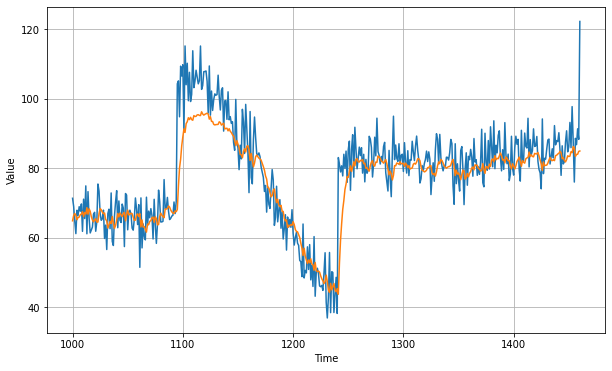

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.4648457